In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
import lightgbm as lgb

# 1️⃣ Load preprocessed feature data
df = pd.read_csv("/home/rupam/DataAlpha/data/raw/processed/final_merged_scores_with_features.csv", parse_dates=['date'])

# 2️⃣ Advanced Feature Engineering
df['reddit_filtered'] = df['reddit_sentiment'].where(df['reddit_sentiment'].abs() > 0.2, 0)
df['news_filtered'] = df['news_sentiment'].where(df['news_sentiment'].abs() > 0.2, 0)
# Ensure roll3 and roll7 exist
for col in ['trend_score', 'reddit_sentiment', 'news_sentiment']:
    df[f'{col}_roll3'] = df.groupby('ticker')[col].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
    df[f'{col}_roll7'] = df.groupby('ticker')[col].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())

# Now momentum works
df['trend_momentum'] = df['trend_score_roll3'] - df['trend_score_roll7']

df['trend_momentum'] = df['trend_score_roll3'] - df['trend_score_roll7']
df['return_roll3'] = df.groupby('ticker')['return'].transform(lambda x: x.shift(1).rolling(3).mean())
df['return_delta'] = df.groupby('ticker')['return'].diff()
df['signal_agreement'] = ((df['reddit_sentiment'] > 0) & (df['trend_score'] > 0)).astype(int) - \
                         ((df['reddit_sentiment'] < 0) & (df['trend_score'] < 0)).astype(int)
# ⏱ Rolling volatility (risk)
df['return_volatility_5'] = df.groupby('ticker')['return'].transform(lambda x: x.shift(1).rolling(5).std())


# 🧠 Interaction terms
df['reddit_trend_agree'] = df['reddit_sentiment'] * df['trend_score']
df['news_trend_agree'] = df['news_sentiment'] * df['trend_score']

# 3️⃣ Clean and prepare
exclude_cols = ['date', 'ticker', 'return', 'target_return', 'target_up']
feature_cols = [col for col in df.columns if col not in exclude_cols]
df = df.dropna(subset=feature_cols + ['target_up'])
X = df[feature_cols]
y = df['target_up']

# 4️⃣ Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5️⃣ Class weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=y_train)
class_weights_dict = {0: weights[0], 1: weights[1]}

# 6️⃣ Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight=class_weights_dict,
    random_state=42
)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]

# 7️⃣ Feature Importance & Selection (Top 15)
importances = pd.Series(rf.feature_importances_, index=feature_cols)
top_features = importances.sort_values(ascending=False).head(15).index.tolist()
X_train_sel = X_train[top_features]
X_test_sel = X_test[top_features]

# 8️⃣ Train LightGBM
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
lgb_model.fit(X_train_sel, y_train)
lgb_probs = lgb_model.predict_proba(X_test_sel)[:, 1]

# 9️⃣ Evaluate at Different Thresholds
thresholds = [(0.35, 0.65), (0.4, 0.6), (0.45, 0.55)]

print("🔍 Evaluation of Confident Predictions Only")
for low, high in thresholds:
    for name, probs in [('Random Forest', rf_probs), ('LightGBM', lgb_probs)]:
        confident_up = probs > high
        confident_down = probs < low
        confident_mask = confident_up | confident_down
        y_pred = np.where(confident_up, 1, 0)
        y_true = y_test[confident_mask]
        y_pred = y_pred[confident_mask]
        print(f"\n📊 {name} | Thresholds: low={low}, high={high}")
        print(f"Confident Predictions: {len(y_true)} / {len(y_test)}")
        print(confusion_matrix(y_true, y_pred))
        print(classification_report(y_true, y_pred))


[LightGBM] [Info] Number of positive: 49248, number of negative: 45196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3430
[LightGBM] [Info] Number of data points in the train set: 94444, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
🔍 Evaluation of Confident Predictions Only

📊 Random Forest | Thresholds: low=0.35, high=0.65
Confident Predictions: 510 / 23612
[[264  16]
 [ 63 167]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       280
           1       0.91      0.73      0.81       230

    accuracy                           0.85       510
   macro avg       0.86      0.83      0.84       510
weighted avg       0

In [24]:
import pandas as pd
import numpy as np

# Load preprocessed feature data
df = pd.read_csv("/home/rupam/DataAlpha/data/raw/processed/final_merged_scores_with_features.csv", parse_dates=['date'])

# Feature engineering
df['reddit_filtered'] = df['reddit_sentiment'].where(df['reddit_sentiment'].abs() > 0.2, 0)
df['news_filtered'] = df['news_sentiment'].where(df['news_sentiment'].abs() > 0.2, 0)

# Rolling features
for col in ['trend_score', 'reddit_sentiment', 'news_sentiment']:
    df[f'{col}_roll3'] = df.groupby('ticker')[col].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
    df[f'{col}_roll7'] = df.groupby('ticker')[col].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())

#momentum
df['trend_momentum'] = df['trend_score_roll3'] - df['trend_score_roll7']
df['return_roll3'] = df.groupby('ticker')['return'].transform(lambda x: x.shift(1).rolling(3).mean())
df['return_delta'] = df.groupby('ticker')['return'].diff()
df['signal_agreement'] = ((df['reddit_sentiment'] > 0) & (df['trend_score'] > 0)).astype(int) - \
                         ((df['reddit_sentiment'] < 0) & (df['trend_score'] < 0)).astype(int)
# ⏱ Rolling volatility (risk)
df['return_volatility_5'] = df.groupby('ticker')['return'].transform(lambda x: x.shift(1).rolling(5).std())


# 🧠 Interaction terms
df['reddit_trend_agree'] = df['reddit_sentiment'] * df['trend_score']
df['news_trend_agree'] = df['news_sentiment'] * df['trend_score']


# Make sure 'date' is datetime and data is sorted
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Drop rows with NA
exclude_cols = ['date', 'ticker', 'return', 'target_return', 'target_up']
feature_cols = [col for col in df.columns if col not in exclude_cols]
df = df.dropna(subset=feature_cols + ['target_up'])


In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

def rolling_backtest(df, feature_cols, label_col='target_up', train_window=60, test_window=20, thresholds=(0.35, 0.65)):
    all_results = []

    for start in range(0, len(df) - train_window - test_window + 1, test_window):
        train_df = df.iloc[start:start + train_window]
        test_df = df.iloc[start + train_window:start + train_window + test_window]

        X_train_full = train_df[feature_cols]
        y_train = train_df[label_col]
        X_test_full = test_df[feature_cols]
        y_test = test_df[label_col].values
        dates = test_df['date'].values
        tickers = test_df['ticker'].values

        # Skip windows with only one class
        unique_classes = np.unique(y_train)
        if len(unique_classes) == 1:
            print(f"[⚠️ Skipped] Only one class ({unique_classes[0]}) in training window starting at {train_df['date'].iloc[0]}")
            continue

        # Compute class weights
        weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
        class_weights_dict = {0: weights[0], 1: weights[1]}

        # Initial RF to get top 15 features
        rf_initial = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=1,
            class_weight=class_weights_dict,
            random_state=42
        )
        rf_initial.fit(X_train_full, y_train)

        importances = pd.Series(rf_initial.feature_importances_, index=feature_cols)
        top_features = importances.sort_values(ascending=False).head(15).index.tolist()

        # Retrain on top features only
        X_train = X_train_full[top_features]
        X_test = X_test_full[top_features]

        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=1,
            class_weight=class_weights_dict,
            random_state=42
        )
        rf.fit(X_train, y_train)
        rf_probs = rf.predict_proba(X_test)[:, 1]

        # Confident prediction logic
        low, high = thresholds
        confident_up = rf_probs > high
        confident_down = rf_probs < low
        confident_mask = confident_up | confident_down

        if confident_mask.sum() == 0:
            print(f"[ℹ️ Info] No confident predictions in window starting {train_df['date'].iloc[0]}")
            continue

        y_pred_conf = np.where(confident_up[confident_mask], 1, 0)
        y_true_conf = y_test[confident_mask]
        date_conf = dates[confident_mask]
        ticker_conf = tickers[confident_mask]
        target_returns = test_df['target_return'].values[confident_mask]

        for p, t, d, tk, r in zip(y_pred_conf, y_true_conf, date_conf, ticker_conf, target_returns):
            all_results.append({
                'date': d,
                'ticker': tk,
                'model': 'Random Forest',
                'pred': p,
                'true': t,
                'target_return': r,
                'pnl': r * (1 if p == 1 else -1)
            })

        print(f"✅ Window {start}-{start+train_window+test_window} | {len(y_pred_conf)} confident trades")

    return pd.DataFrame(all_results)


In [ ]:
results_df = rolling_backtest(df, feature_cols)
# Save results
results_df.to_csv('/home/rupam/DataAlpha/data/rolling_backtest_results.csv', index=False)

✅ Window 0-80 | 14 confident trades
✅ Window 20-100 | 15 confident trades
✅ Window 40-120 | 8 confident trades
✅ Window 60-140 | 16 confident trades
✅ Window 80-160 | 17 confident trades
✅ Window 100-180 | 15 confident trades
✅ Window 120-200 | 14 confident trades
✅ Window 140-220 | 18 confident trades
✅ Window 160-240 | 15 confident trades
✅ Window 180-260 | 18 confident trades
✅ Window 200-280 | 18 confident trades
✅ Window 220-300 | 12 confident trades
✅ Window 240-320 | 16 confident trades
✅ Window 260-340 | 14 confident trades
✅ Window 280-360 | 15 confident trades
✅ Window 300-380 | 16 confident trades
✅ Window 320-400 | 18 confident trades
✅ Window 340-420 | 15 confident trades
✅ Window 360-440 | 13 confident trades
✅ Window 380-460 | 10 confident trades
✅ Window 400-480 | 14 confident trades
✅ Window 420-500 | 16 confident trades
✅ Window 440-520 | 11 confident trades
✅ Window 460-540 | 9 confident trades
✅ Window 480-560 | 5 confident trades
✅ Window 500-580 | 6 confident trad

In [29]:
# Sort by date
results_df['date'] = pd.to_datetime(results_df['date'])
results_df = results_df.sort_values('date')

# Daily returns
daily_pnl = results_df.groupby('date')['pnl'].mean()
cumulative_return = (1 + daily_pnl).cumprod()

# Risk metrics
def sharpe_ratio(r): return np.sqrt(252) * r.mean() / (r.std() + 1e-8)
def max_drawdown(c): return (c / c.cummax() - 1).min()
def cagr(c): return c.iloc[-1]**(252 / len(c)) - 1

print("📊 Final Risk Metrics:")
print(f"Sharpe Ratio: {sharpe_ratio(daily_pnl):.2f}")
print(f"Max Drawdown: {max_drawdown(cumulative_return):.2%}")
print(f"CAGR: {cagr(cumulative_return):.2%}")


📊 Final Risk Metrics:
Sharpe Ratio: 13.91
Max Drawdown: -0.08%
CAGR: 4975.69%


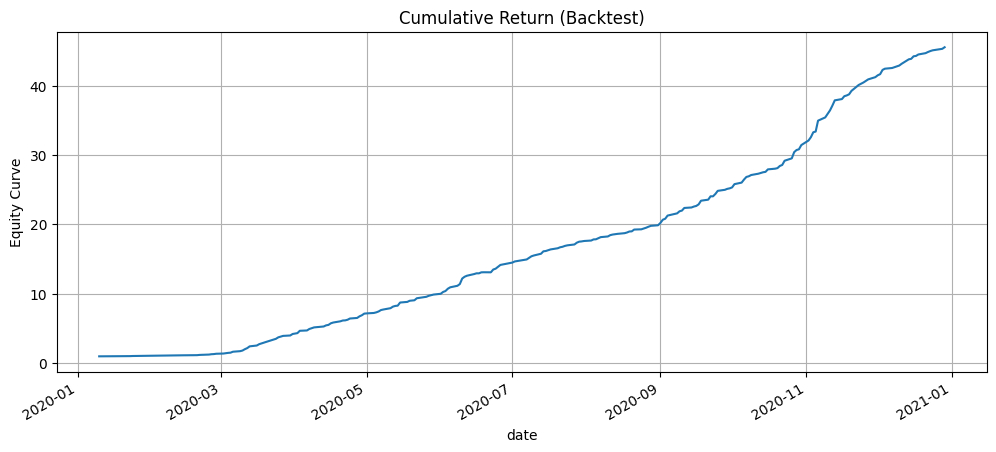

In [32]:
import matplotlib.pyplot as plt

cumulative_return.plot(title='Cumulative Return (Backtest)', figsize=(12, 5))
plt.ylabel("Equity Curve")
plt.grid(True)
plt.show()


In [ ]:
results_df['pnl'].hist(bins=50)
plt.title("Distribution of Trade PnLs")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


        date          model   pnl_net  cum_return
0 2020-01-10  Random Forest  2.029104    2.029104
1 2020-01-13  Random Forest -0.179690    1.849414
2 2020-01-14  Random Forest  0.067598    1.917012
3 2020-01-15  Random Forest  3.360927    5.277939
4 2020-01-16  Random Forest  0.223637    5.501576


/tmp/ipykernel_21024/2818087812.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/rupam/DataAlpha/alphaenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


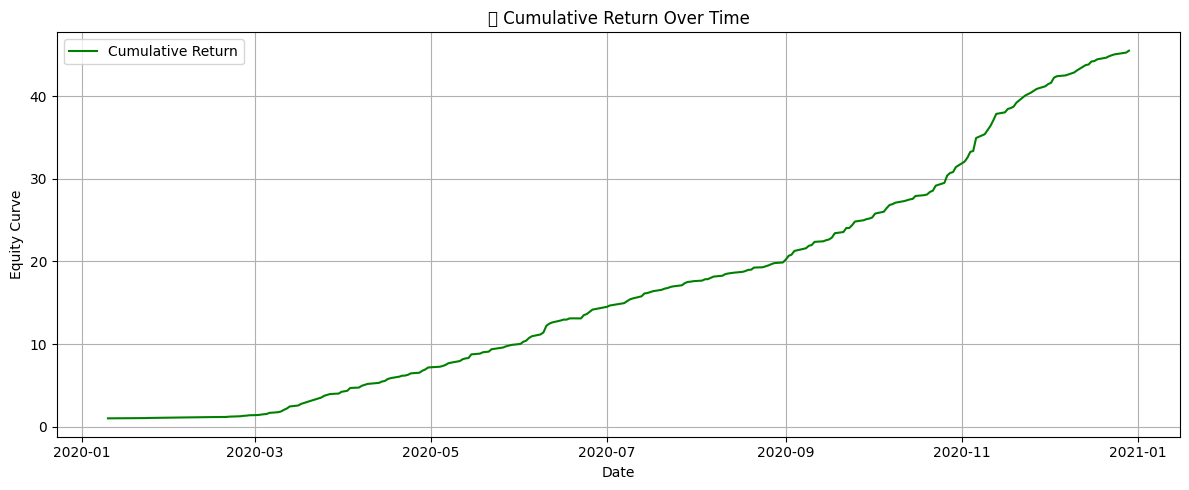

In [33]:
import matplotlib.pyplot as plt

# Make sure 'date' is datetime and sorted
results_df['date'] = pd.to_datetime(results_df['date'])
results_df = results_df.sort_values('date')

# Compute daily PnL
daily_pnl = results_df.groupby('date')['pnl'].mean()

# Compute cumulative return
cumulative_return = (1 + daily_pnl).cumprod()

# Plot it
plt.figure(figsize=(12, 5))
plt.plot(cumulative_return, label='Cumulative Return', color='green')
plt.title("📈 Cumulative Return Over Time")
plt.xlabel("Date")
plt.ylabel("Equity Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_21024/282954470.py:6: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/rupam/DataAlpha/alphaenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


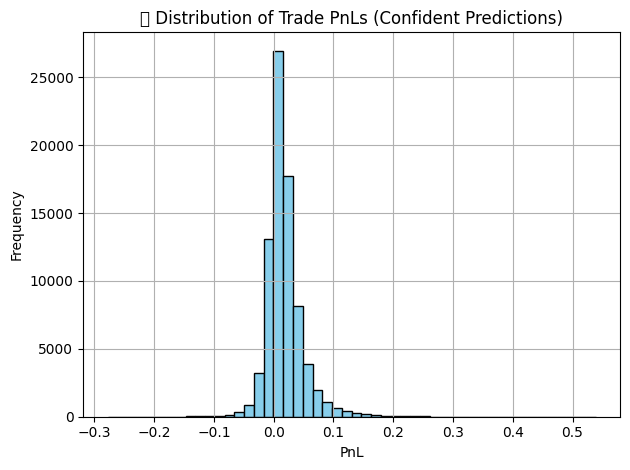

In [34]:
results_df['pnl'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title("💰 Distribution of Trade PnLs (Confident Predictions)")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
acc = (results_df['pred'] == results_df['true']).mean()
print(f"✅ Confident Prediction Accuracy: {acc:.2%}")
# Save predictions and backtest result
results_df.to_csv("/home/rupam/DataAlpha/data/backtest_rf_confident_predictions.csv", index=False)

# Optionally, save daily PnL
daily_pnl.to_csv("/home/rupam/DataAlpha/data/daily_pnl.csv")


NameError: name 'results_df' is not defined